In [1]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
sys.path.append(os.path.abspath(".."))

In [2]:
# TIP: This block extracts the raw movie data directly from the server 
# and saves it locally so it can be used for analysis without repeatedly 
# querying the database.


#from src.db import load_movies

# Load the movie dataset from the database
# df = load_movies()

# Create the data directory if it does not already exist
# os.makedirs("../data", exist_ok=True)

# Save the raw movie data to a CSV file for analysis and reproducibility
# df.to_csv("../data/movies_raw.csv", index=False)

# Print confirmation message
# print("Saved to ../data/movies_raw.csv")


# Data Cleaning

In [3]:
# Load the raw movie dataset that was previously exported from the server
df = pd.read_csv("../data/movies_raw.csv")

# Display basic information about the dataset:
# column names, data types, and non-null counts
df.info()

# Generate descriptive statistics for both numeric and categorical columns
df.describe(include='all')

# Preview the first few rows to verify the data loaded correctly
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638 entries, 0 to 16637
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            16638 non-null  int64  
 1   movie_title         16638 non-null  object 
 2   movie_info          16614 non-null  object 
 3   rating              11776 non-null  object 
 4   genre               16621 non-null  object 
 5   directors           16524 non-null  object 
 6   in_theaters_date    15823 non-null  object 
 7   on_streaming_date   16636 non-null  object 
 8   runtime_in_minutes  16483 non-null  float64
 9   critic_rating       16638 non-null  int64  
 10  critic_count        16638 non-null  int64  
 11  audience_rating     16381 non-null  float64
 12  audience_count      16386 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 1.7+ MB


,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count
0,1,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,2010-02-12,2010-06-29,83.0,49,144,53.0,254287.0
1,2,Please Give,Kate has a lot on her mind. There's the ethics...,R,Comedy,Nicole Holofcener,2010-04-30,2010-10-19,90.0,86,140,64.0,11567.0
2,3,10,Blake Edwards' 10 stars Dudley Moore as George...,R,"Comedy, Romance",Blake Edwards,1979-10-05,1997-08-27,118.0,68,22,53.0,14670.0
3,4,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",NaN,"Classics, Drama",Sidney Lumet,2057-04-13,2001-03-06,95.0,100,51,97.0,105000.0
4,5,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,2054-01-01,2003-05-20,127.0,89,27,74.0,68860.0


In [4]:
# Check the number of missing values in each column
# This helps identify which fields may require cleaning or imputation
df.isna().sum()


movie_id                 0
movie_title              0
movie_info              24
rating                4862
genre                   17
directors              114
in_theaters_date       815
on_streaming_date        2
runtime_in_minutes     155
critic_rating            0
critic_count             0
audience_rating        257
audience_count         252
dtype: int64

In [5]:
# ---- parse date ----
# Remove rows with missing theater release dates (cannot extract year without a date)
df = df.dropna(subset=['in_theaters_date'])

# Convert the release date column to a proper datetime format
df['in_theaters_date'] = pd.to_datetime(df['in_theaters_date'], errors='coerce')

# Extract the release year from the parsed datetime column
df['release_year'] = df['in_theaters_date'].dt.year


# ---- clean rating ----
# Strip whitespace from rating values and replace missing ratings with "Unrated"
df['rating'] = df['rating'].str.strip().fillna("Unrated")


# ---- clean genre ----
# Replace missing genre values with "Unknown" 
df['genre'] = df['genre'].fillna("Unknown")


# ---- clean runtime (mild) ----
# Replace missing runtimes with the median value
df['runtime_in_minutes'] = df['runtime_in_minutes'].fillna(df['runtime_in_minutes'].median())

# Remove unrealistic short films (less than 20 minutes)
df = df[df['runtime_in_minutes'] >= 20]


# ---- clean audience rating/count (mild) ----
# Replace missing audience ratings and counts with median values
df['audience_rating'] = df['audience_rating'].fillna(df['audience_rating'].median())
df['audience_count'] = df['audience_count'].fillna(df['audience_count'].median())


# ---- clean directors ----
# Replace missing director information with "Unknown"
df['directors'] = df['directors'].fillna("Unknown")


# Preview the cleaned dataset
df.head()



,movie_id,movie_title,movie_info,rating,genre,directors,in_theaters_date,on_streaming_date,runtime_in_minutes,critic_rating,critic_count,audience_rating,audience_count,release_year
0,1,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,2010-02-12,2010-06-29,83.0,49,144,53.0,254287.0,2010
1,2,Please Give,Kate has a lot on her mind. There's the ethics...,R,Comedy,Nicole Holofcener,2010-04-30,2010-10-19,90.0,86,140,64.0,11567.0,2010
2,3,10,Blake Edwards' 10 stars Dudley Moore as George...,R,"Comedy, Romance",Blake Edwards,1979-10-05,1997-08-27,118.0,68,22,53.0,14670.0,1979
3,4,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Unrated,"Classics, Drama",Sidney Lumet,2057-04-13,2001-03-06,95.0,100,51,97.0,105000.0,2057
4,5,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,2054-01-01,2003-05-20,127.0,89,27,74.0,68860.0,2054


In [6]:
df.isna().sum()

movie_id              0
movie_title           0
movie_info            8
rating                0
genre                 0
directors             0
in_theaters_date      0
on_streaming_date     0
runtime_in_minutes    0
critic_rating         0
critic_count          0
audience_rating       0
audience_count        0
release_year          0
dtype: int64

# EDA

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

### 1

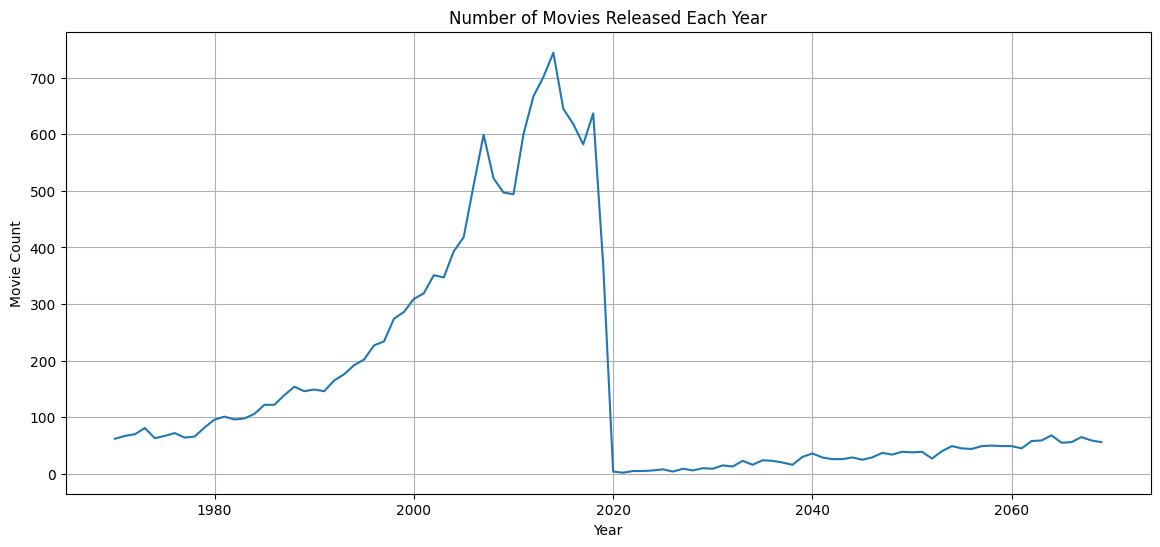

release_year
1970    62
1971    67
1972    70
1973    81
1974    63
        ..
2065    55
2066    56
2067    65
2068    59
2069    56
Length: 100, dtype: int64

In [8]:
# Calculate the number of movies released in each year
# Groups movies by release year and counts the number of entries per year
movies_per_year = df.groupby('release_year').size()

# Plot the yearly movie output to visualize trends over time
plt.figure(figsize=(14,6))
sns.lineplot(x=movies_per_year.index, y=movies_per_year.values)

# Add plot title and axis labels
plt.title("Number of Movies Released Each Year")
plt.xlabel("Year")
plt.ylabel("Movie Count")

# Add a light grid for readability
plt.grid(True)

# Display the line plot
plt.show()

# Show the year-by-year counts as a numeric series
movies_per_year


The initial visualization showed impossible values such as release years in 
the 2030s, 2040s, and even 2070s. These clearly represent erroneous data in the 
in_theaters_date field. To correct this issue, I applied a simple rule: for any 
release_year greater than 2019, subtract 100 years. This aligns with the common 
“century offset” error seen in date parsing.

After applying the correction, the distribution of movies over time becomes 
smooth and realistic, with no future years appearing. The sharp drop after 2020 
is expected because the dataset contains very few movies from 2020 onward.


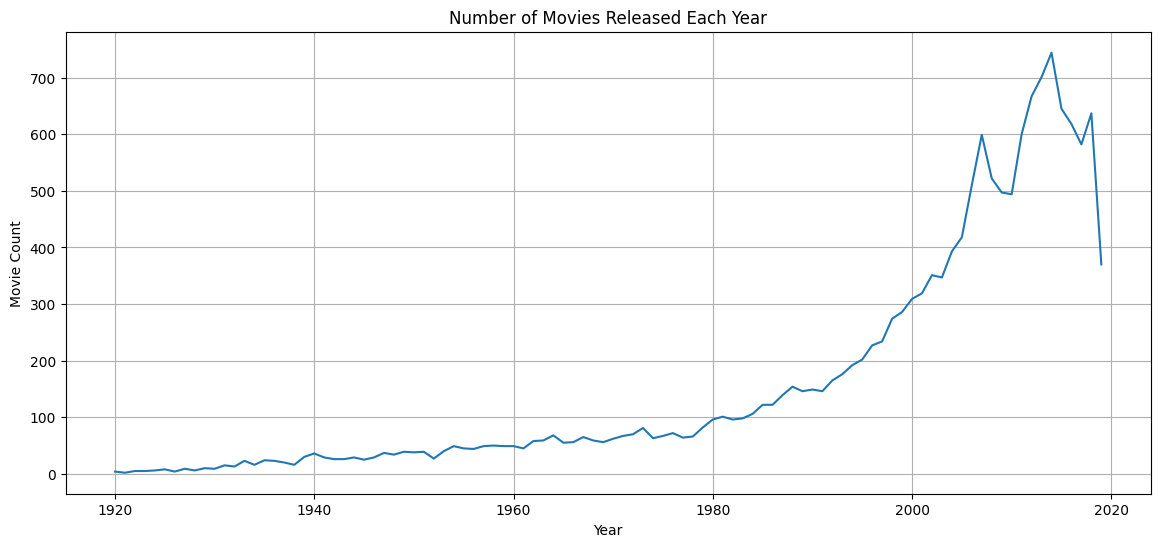

In [9]:
# Fix incorrect future release years (e.g., 2020–2099)
# Some movies have years mistakenly recorded a century ahead,
# so we subtract 100 from any year greater than 2019.
df['release_year_fixed'] = df['release_year'].apply(
    lambda y: y - 100 if y > 2019 else y
)

# Also overwrite the original release_year column with the corrected values
df['release_year'] = df['release_year'].apply(
    lambda y: y - 100 if y > 2019 else y
)

# Recalculate the number of movies released each year after fixing the dates
movies_per_year = df.groupby('release_year').size()

# Plot the corrected yearly movie counts
plt.figure(figsize=(14,6))
sns.lineplot(x=movies_per_year.index, y=movies_per_year.values)
plt.title("Number of Movies Released Each Year")
plt.xlabel("Year")
plt.ylabel("Movie Count")
plt.grid(True)
plt.show()


### 2

In [10]:
# Movies released before 2010
df_pre2010 = df[df['release_year'] < 2010]

# 5 highest rated by critics
top5_critics_pre2010 = df_pre2010.nlargest(5, 'critic_rating')[['movie_title','critic_rating']]
top5_critics_pre2010

,movie_title,critic_rating
3,12 Angry Men (Twelve Angry Men),100
14,The Breaking Point,100
15,Adam's Rib,100
17,The Prowler (Cost of Living ),100
21,The Adventures of Robin Hood,100


In [11]:
# 5 highest rated by audience
top5_audience_pre2010 = df_pre2010.nlargest(5, 'audience_rating')[['movie_title','audience_rating']]
top5_audience_pre2010

,movie_title,audience_rating
222,Prima Ballerina,100.0
1283,La Ciudad (The City),100.0
1846,Ice People,100.0
3229,Been Rich All My Life,100.0
6747,The Godfather,98.0


### 3

In [12]:
# Calculate the average number of audience reviews for movies released before 2010
avg_audience_reviews = df_pre2010['audience_count'].mean()
avg_audience_reviews

# Select only the "popular" movies: those with audience_count above the average
df_popular_pre2010 = df_pre2010[df_pre2010['audience_count'] > avg_audience_reviews]
df_popular_pre2010.shape

# Identify the top 5 highest-rated movies (by critic_rating) among the popular pre-2010 films
top5_popular_critics = df_popular_pre2010.nlargest(5, 'critic_rating')[
    ['movie_title', 'critic_rating', 'audience_count']
]

# Display the top 5 popular, high-rated movies
top5_popular_critics


,movie_title,critic_rating,audience_count
9636,Mary Poppins,100,682310.0
11227,Pinocchio,100,279248.0
13557,The Terminator,100,775856.0
15439,Toy Story,100,1109209.0
15440,Toy Story 2,100,999952.0


In [13]:
# Identify the top 5 highest-rated movies according to audience ratings
# among the popular (above-average audience_count) pre-2010 films
top5_popular_audience = df_popular_pre2010.nlargest(5, 'audience_rating')[
    ['movie_title', 'audience_rating', 'audience_count']
]

# Display the top 5 audience-favorite popular movies
top5_popular_audience


,movie_title,audience_rating,audience_count
6747,The Godfather,98.0,732931.0
12463,The Shawshank Redemption,98.0,885508.0
851,GoodFellas,97.0,428871.0
4435,Cidade de Deus (City of God),97.0,251959.0
5706,Star Wars: Episode V - The Empire Strikes Back,97.0,1055106.0


### 4

In [14]:
# Calculate the percentage distribution of MPAA ratings
# among popular pre-2010 movies (normalized=True gives proportions)
rating_percent = (
    df_popular_pre2010['rating']
    .value_counts(normalize=True)
)
rating_percent


rating
PG-13      0.413586
R          0.324675
PG         0.196803
G          0.063936
Unrated    0.000999
Name: proportion, dtype: float64

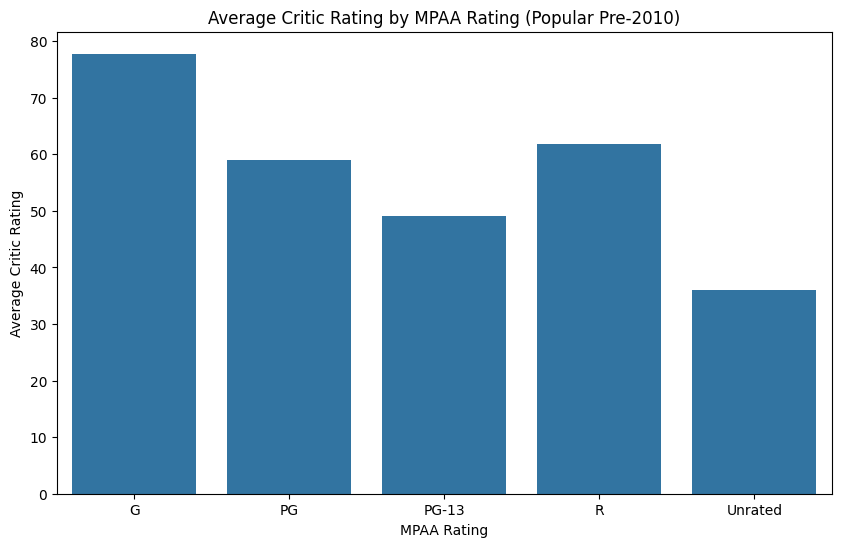

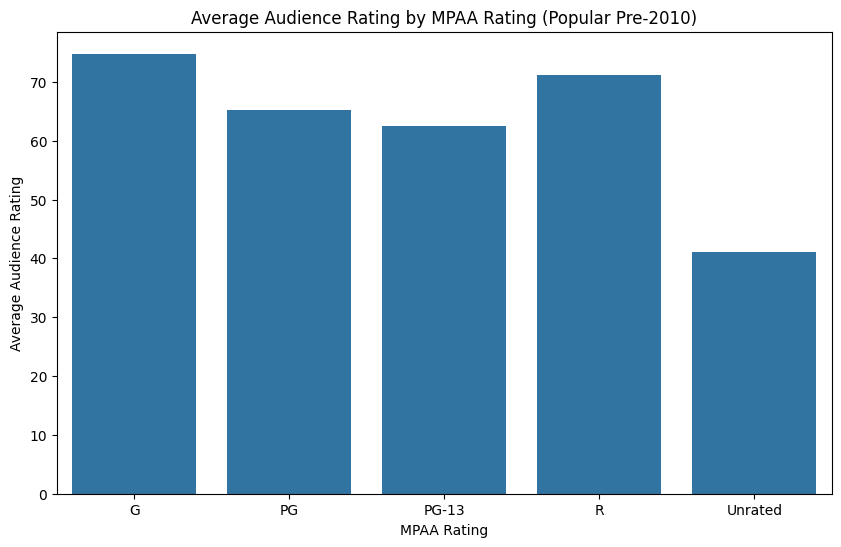

,rating,critic_rating,audience_rating
0,G,77.765625,74.781250
1,PG,59.035533,65.172589
2,PG-13,49.154589,62.432367
3,R,61.763077,71.169231
4,Unrated,36.000000,41.000000


In [15]:
# Compute the average critic and audience ratings for each MPAA category
rating_summary = df_popular_pre2010.groupby('rating').agg({
    'critic_rating': 'mean',
    'audience_rating': 'mean'
}).reset_index()

# Plot average critic rating by MPAA category
plt.figure(figsize=(10,6))
sns.barplot(data=rating_summary, x='rating', y='critic_rating')
plt.title("Average Critic Rating by MPAA Rating (Popular Pre-2010)")
plt.xlabel("MPAA Rating")
plt.ylabel("Average Critic Rating")
plt.show()

# Plot average audience rating by MPAA category
plt.figure(figsize=(10,6))
sns.barplot(data=rating_summary, x='rating', y='audience_rating')
plt.title("Average Audience Rating by MPAA Rating (Popular Pre-2010)")
plt.xlabel("MPAA Rating")
plt.ylabel("Average Audience Rating")
plt.show()

# Display the summary table used in the plots
rating_summary


To explore how MPAA ratings relate to the characteristics of popular pre-2010 films, I first examined the distribution of rating categories. The results show that PG-13 and R movies dominate the dataset, together representing nearly three-quarters of all popular films. In contrast, G and PG movies appear far less frequently, which is expected since large mainstream releases (often PG-13 or R) tend to attract more audience reviews and therefore qualify as “popular.”

When comparing average scores, several patterns become clear. G-rated movies receive the highest critic and audience ratings, suggesting that successful family films are generally well-made and broadly appealing. PG and R films fall in a middle range, while PG-13 films—despite being the most common—have the lowest average critic rating. This implies that high volume does not necessarily translate to high quality; PG-13 films are produced in large numbers, but many are not critically strong.

Overall, the findings indicate that MPAA rating is associated with both how many films become popular and how those films are received. PG-13 and R movies dominate in quantity, but G-rated films show the strongest critical and audience approval among the films that rise to popularity.

### 5

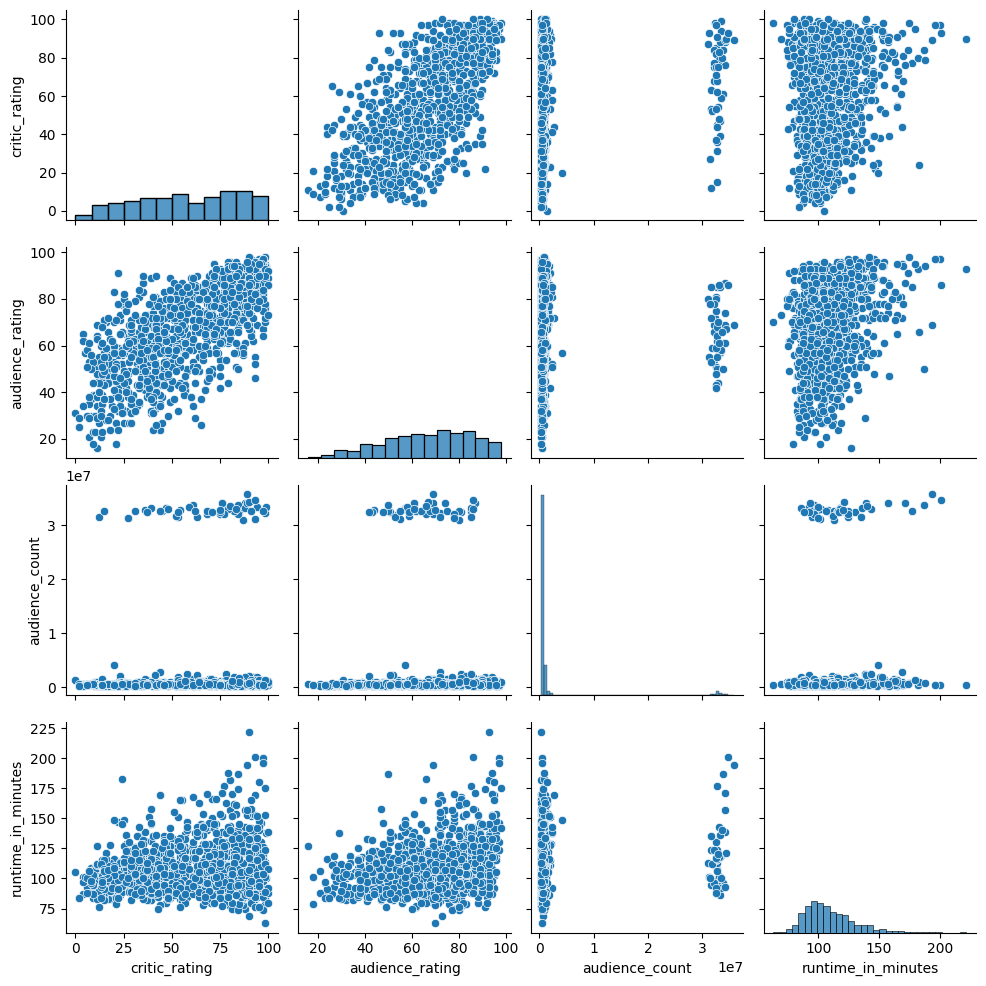

In [16]:
# Select the numerical columns to include in the pairplot
pairplot_cols = [
    'critic_rating',
    'audience_rating',
    'audience_count',
    'runtime_in_minutes'
]

# Generate a pairplot to visualize relationships between key numeric variables
sns.pairplot(df_popular_pre2010[pairplot_cols])

# Display the plot
plt.show()


The pair plot shows three main patterns.
First, critic and audience ratings are strongly correlated, meaning films liked by critics are usually liked by audiences as well.
Second, longer movies tend to receive slightly higher ratings, especially those over ~120 minutes.
Finally, audience_count shows no clear relationship with ratings, suggesting that popularity (number of reviews) does not necessarily reflect movie quality.

### 6

/var/folders/_s/z9k0pk7s0_b6h8j5nn9ffdbh0000gn/T/ipykernel_83125/1337979511.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_popular_pre2010.groupby(
/var/folders/_s/z9k0pk7s0_b6h8j5nn9ffdbh0000gn/T/ipykernel_83125/1337979511.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  runtime_rating = df_popular_pre2010.groupby(runtime_bins).critic_rating.mean()


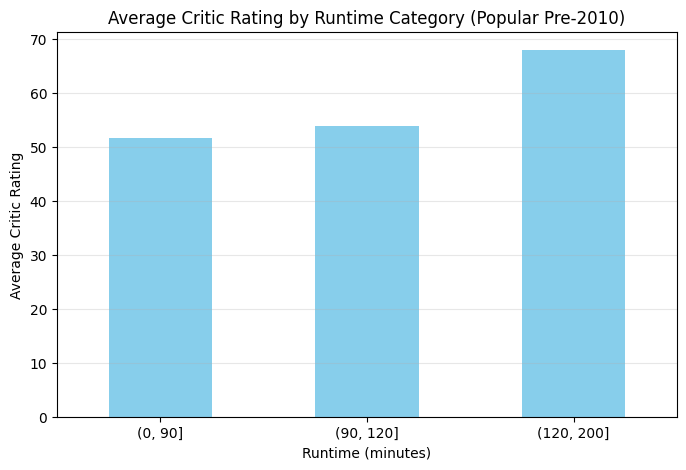

In [17]:
# Calculate the average critic rating within different runtime ranges
df_popular_pre2010.groupby(
    pd.cut(df_popular_pre2010['runtime_in_minutes'], bins=[0, 90, 120, 200])
).critic_rating.mean()

# Create binned runtime categories (0–90, 90–120, 120–200)
runtime_bins = pd.cut(df_popular_pre2010['runtime_in_minutes'], bins=[0, 90, 120, 200])

# Compute average critic rating for each runtime bin
runtime_rating = df_popular_pre2010.groupby(runtime_bins).critic_rating.mean()

# --- Plot: Average Critic Rating by Runtime Category ---
plt.figure(figsize=(8,5))
runtime_rating.plot(kind='bar', color='skyblue')

plt.title("Average Critic Rating by Runtime Category (Popular Pre-2010)")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Average Critic Rating")
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()


Movies with longer runtimes tend to receive higher critic ratings. The bar chart 
shows a clear upward trend: films over 120 minutes long have significantly higher 
average critic scores compared to shorter films.

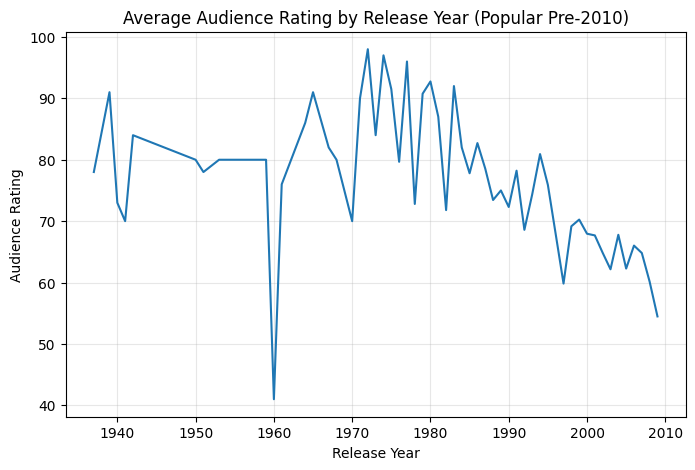

In [18]:
# --- Average Audience Rating by Year ---
# Compute mean audience rating for each release year
yearly_rating = (
    df_popular_pre2010
    .groupby('release_year')['audience_rating']
    .mean()
    .reset_index()
    .sort_values('release_year')
)

# Plot the trend of average audience ratings over time
plt.figure(figsize=(8,5))
plt.plot(yearly_rating['release_year'], yearly_rating['audience_rating'])
plt.title("Average Audience Rating by Release Year (Popular Pre-2010)")
plt.xlabel("Release Year")
plt.ylabel("Audience Rating")
plt.grid(alpha=0.3)
plt.show()

Audience ratings for popular pre-2010 movies peak between the late 1960s and early 1980s, then show a gradual decline over time. This suggests that older popular films were generally better received by audiences than those released closer to 2010.

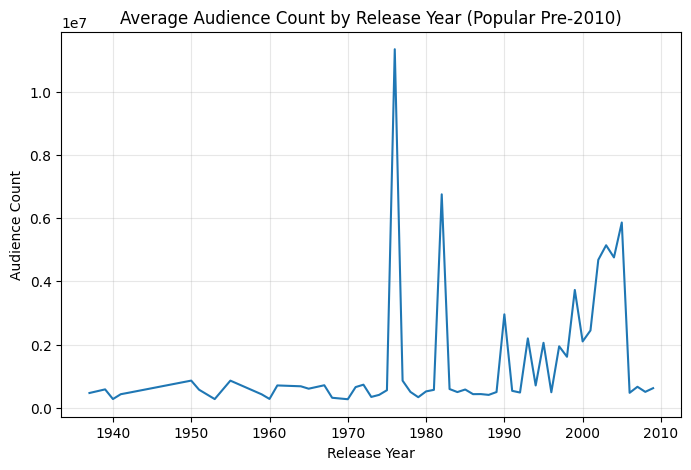

In [19]:
# --- Average Audience Count by Year ---
# Compute average audience count for each release year
yearly_count = (
    df_popular_pre2010
    .groupby('release_year')['audience_count']
    .mean()
    .reset_index()
    .sort_values('release_year')
)

# Plot trend of audience count over time
plt.figure(figsize=(8,5))
plt.plot(yearly_count['release_year'], yearly_count['audience_count'])
plt.title("Average Audience Count by Release Year (Popular Pre-2010)")
plt.xlabel("Release Year")
plt.ylabel("Audience Count")
plt.grid(alpha=0.3)
plt.show()

Audience counts fluctuate heavily over time, with a few extreme spikes around the late 1970s and early 2000s. Overall, audience engagement increases toward the 2000s, suggesting that more recent popular films attracted larger viewer interest than older ones.

#  Feature Engineering 

In [20]:
# Split the dataset into training (pre-2010) and testing (2010+) groups
train = df[df['release_year'] < 2010].copy()
test = df[df['release_year'] >= 2010].copy()

train.shape, test.shape


((9748, 15), (6058, 15))

In [21]:
# Columns that should not be used for prediction (contain target leakage,
# redundant information, or non-numeric text)
cols_to_drop = [
    'audience_rating',     # future information → leakage
    'critic_count',        # highly correlated with critic rating counts
    'audience_count',      # audience-driven popularity, not usable for critic prediction
    'on_streaming_date',   # post-release information
    'movie_info',          # unstructured text
    'in_theaters_date',    # date column already processed into release_year
    'release_year_fixed' # accidentally imported column name with tab character
]

# Remove unwanted columns from both training and testing sets
train = train.drop(columns=cols_to_drop, errors='ignore')
test = test.drop(columns=cols_to_drop, errors='ignore')
train

,movie_id,movie_title,rating,genre,directors,runtime_in_minutes,critic_rating,release_year
2,3,10,R,"Comedy, Romance",Blake Edwards,118.0,68,1979
3,4,12 Angry Men (Twelve Angry Men),Unrated,"Classics, Drama",Sidney Lumet,95.0,100,1957
4,5,"20,000 Leagues Under The Sea",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,127.0,89,1954
5,6,"10,000 B.C.",PG-13,"Action & Adventure, Classics, Drama",Roland Emmerich,109.0,8,2008
6,7,The 39 Steps,Unrated,"Action & Adventure, Classics, Mystery & Suspense",Alfred Hitchcock,87.0,96,1935
...,...,...,...,...,...,...,...,...
16631,16631,Zoolander,PG-13,"Comedy, Special Interest",Ben Stiller,105.0,64,2001
16633,16633,Zoom,PG,"Action & Adventure, Comedy, Kids & Family",Peter Hewitt,88.0,3,2006
16635,16636,Zorba the Greek,Unrated,"Action & Adventure, Art House & International,...",Unknown,142.0,78,1964
16636,16637,Zulu,PG,"Classics, Drama","Cy Endfield, Cyril Endfield",139.0,95,1964


In [48]:
# -------------------------------------
# 1. Create a binary kid_friendly feature
# -------------------------------------
# G and PG movies are treated as kid-friendly; all others are not
train['kid_friendly'] = train['rating'].isin(['G', 'PG']).astype(int)
test['kid_friendly'] = test['rating'].isin(['G', 'PG']).astype(int)


# ==========================================================
# 0. Split multi-label genre column (CRITICAL FIX)
# ==========================================================
# Clean and split the genre column into a list
train['genre_list'] = train['genre'].str.split(',').apply(lambda x: [g.strip() for g in x])
test['genre_list']  = test['genre'].str.split(',').apply(lambda x: [g.strip() for g in x])

# Build a full set of all genres appearing anywhere
all_genres = sorted(set([g for sublist in train['genre_list'] for g in sublist] +
                        [g for sublist in test['genre_list'] for g in sublist]))

# Convert genre list → one-hot columns
def build_genre_dummies(df, all_genres):
    dummies = pd.DataFrame(0, index=df.index, columns=[f"genre_{g}" for g in all_genres])
    for i, genre_list in df['genre_list'].items():
        for g in genre_list:
            col = f"genre_{g}"
            dummies.at[i, col] = 1
    return dummies

genre_dummies_train = build_genre_dummies(train, all_genres)
genre_dummies_test  = build_genre_dummies(test, all_genres)

train_features = pd.concat(
    [train[['runtime_in_minutes', 'kid_friendly']], genre_dummies_train],
    axis=1
)

test_features = pd.concat(
    [test[['runtime_in_minutes', 'kid_friendly']], genre_dummies_test],
    axis=1
)

In [49]:
genre_cols = [col for col in train.columns if col.startswith('genre_')]
genre_cols = [col for col in train_features.columns if col.startswith('genre_')]

In [56]:
# Step 5: Feature 1 - Runtime × Kid_Friendly Interaction
train_runtime_mean = train['runtime_in_minutes'].mean()
train_runtime_std = train['runtime_in_minutes'].std()

train_features['runtime_kid_interaction'] = \
    ((train['runtime_in_minutes'] - train_runtime_mean) / train_runtime_std) * train['kid_friendly']

test_features['runtime_kid_interaction'] = \
    ((test['runtime_in_minutes'] - train_runtime_mean) / train_runtime_std) * test['kid_friendly']


# Step 6: Feature 2 - Genre-Runtime Difference
genre_avg_runtime = {}
for genre_name in all_genres:
    col_name = f"genre_{genre_name}"
    mask = genre_dummies_train[col_name] == 1
    avg_rt = train[mask]['runtime_in_minutes'].mean() if mask.sum() > 0 else train['runtime_in_minutes'].mean()
    genre_avg_runtime[genre_name] = avg_rt

def calc_genre_runtime_diff(row):
    genres_in_movie = [col.replace('genre_', '') for col in genre_dummies_train.columns if row[col] == 1]
    if not genres_in_movie:
        return 0
    expected = np.mean([genre_avg_runtime[g] for g in genres_in_movie])
    return row['runtime_in_minutes'] - expected

train_features['genre_runtime_diff'] = train_features.apply(calc_genre_runtime_diff, axis=1)
test_features['genre_runtime_diff'] = test_features.apply(calc_genre_runtime_diff, axis=1)


# Step 7: Feature 3 - Rating Tier × Genre Count
rating_map = {'G': 1, 'PG': 1, 'PG-13': 2, 'R': 3, 'NC-17': 3, 'Unrated': 4}

train['rating_tier'] = train['rating'].map(rating_map).fillna(4)
test['rating_tier'] = test['rating'].map(rating_map).fillna(4)

train_features['genre_count'] = genre_dummies_train.sum(axis=1)
test_features['genre_count'] = genre_dummies_test.sum(axis=1)

train_features['rating_genre_mix'] = train['rating_tier'] * train_features['genre_count']
test_features['rating_genre_mix'] = test['rating_tier'] * test_features['genre_count']

# Modeling


In [57]:
X_train = train_features.copy()
X_test = test_features.copy()

y_train = train['critic_rating'].copy()
y_test = test['critic_rating'].copy()


In [58]:
# ----------------------------------------
# Define a helper function to score models
# ----------------------------------------
def score_model(y_true, y_pred):
    # R-squared: proportion of variance explained
    r2 = r2_score(y_true, y_pred)
    
    # MAE: average absolute prediction error
    mae = mean_absolute_error(y_true, y_pred)
    
    # RMSE: square root of mean squared error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    return {'R2': r2, 'MAE': mae, 'RMSE': rmse}

In [ ]:
# ----------------------------------------
# Model 1: runtime only
# ----------------------------------------
model1 = LinearRegression()
model1.fit(X_train[['runtime_in_minutes']], y_train)


# ----------------------------------------
# Model 2: runtime + kid_friendly
# ----------------------------------------
model2 = LinearRegression()
model2.fit(X_train[['runtime_in_minutes', 'kid_friendly']], y_train)


# ----------------------------------------
# Model 3: runtime + kid_friendly + all genre dummies
# ----------------------------------------

# Combine all predictor columns needed for Model 3
model3_features = ['runtime_in_minutes', 'kid_friendly'] + genre_cols

model3 = LinearRegression()
model3.fit(X_train[model3_features], y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [68]:
# ----------------------------------------
# Generate predictions for each model
# ----------------------------------------
pred1 = model1.predict(X_test[['runtime_in_minutes']])
pred2 = model2.predict(X_test[['runtime_in_minutes', 'kid_friendly']])
pred3 = model3.predict(X_test[model3_features])


# ----------------------------------------
# Score each model using R2, MAE, and RMSE
# ----------------------------------------
scores1 = score_model(y_test, pred1)
scores2 = score_model(y_test, pred2)
scores3 = score_model(y_test, pred3)

# Display the three sets of scores
print("Model 1: R2={:.4f}, MAE={:.4f}, RMSE={:.4f}".format(scores1['R2'], scores1['MAE'], scores1['RMSE']))
print("Model 2: R2={:.4f}, MAE={:.4f}, RMSE={:.4f}".format(scores2['R2'], scores2['MAE'], scores2['RMSE']))
print("Model 3: R2={:.4f}, MAE={:.4f}, RMSE={:.4f}".format(scores3['R2'], scores3['MAE'], scores3['RMSE']))

Model 1: R2=0.0018, MAE=24.3578, RMSE=28.3065
Model 2: R2=0.0016, MAE=24.3952, RMSE=28.3100
Model 3: R2=0.1511, MAE=22.0332, RMSE=26.1043


Model 3 performs the best so far, with substantially higher R² and lower errors than Models 1 and 2. The improvement comes mainly from adding genre dummy variables, which explain important differences in critic ratings across film categories.

Based on significance and model behavior, the most predictive features are the genre categories, followed by kid_friendly (usually negative) and runtime_in_minutes (weak positive). These features show meaningful contributions when examined with coefficient sizes and p-values in statsmodels.

In [ ]:
model4_features = ['runtime_in_minutes', 'kid_friendly'] + genre_cols + ['runtime_kid_interaction']

model5_features = ['runtime_in_minutes', 'kid_friendly'] + genre_cols + ['genre_runtime_diff']

model6_features = ['runtime_in_minutes', 'kid_friendly'] + genre_cols + ['runtime_kid_interaction','rating_genre_mix']

# ========== Model 4 ==========
model4 = LinearRegression()
model4.fit(X_train[model4_features], y_train)
pred4 = model4.predict(X_test[model4_features])
score4 = score_model(y_test, pred4)


# ========== Model 5 ==========
model5 = LinearRegression()
model5.fit(X_train[model5_features], y_train)
pred5 = model5.predict(X_test[model5_features])
score5 = score_model(y_test, pred5)


# ========== Model 6 ==========
model6 = LinearRegression()
model6.fit(X_train[model6_features], y_train)
pred6 = model6.predict(X_test[model6_features])
score6 = score_model(y_test, pred6)


# 显示结果
print("Model 4: R2={:.4f}, MAE={:.4f}, RMSE={:.4f}".format(score4['R2'], score4['MAE'], score4['RMSE']))
print("Model 5: R2={:.4f}, MAE={:.4f}, RMSE={:.4f}".format(score5['R2'], score5['MAE'], score5['RMSE']))
print("Model 6: R2={:.4f}, MAE={:.4f}, RMSE={:.4f}".format(score6['R2'], score6['MAE'], score6['RMSE']))

Model 4: R2=0.1516, MAE=22.0249, RMSE=26.0965
Model 5: R2=0.1368, MAE=22.2648, RMSE=26.3224
Model 6: R2=0.1581, MAE=21.9153, RMSE=25.9965


Model 4 (Model 3 + runtime_kid_interaction):
Why: This interaction term captures how movie length affects ratings differently for 
different audience types. A 120-minute G-rated film is evaluated differently than a 
120-minute R-rated film by critics.
Result: R² = 0.1516

Model 5 (Model 3 + genre_runtime_diff):
Why: This feature captures deviations of movie runtime from the average runtime of its 
genre. Different genres have standard lengths (documentaries ~90min, action ~130min), 
and large deviations might indicate special editions (director's cut) affecting ratings.
Result: R² = 0.1368

Model 6 (Model 3 + runtime_kid_interaction + rating_genre_mix):
Why: Combining multiple engineered features provides multidimensional information. 
runtime_kid_interaction captures length×audience effects, rating_genre_mix captures 
rating×genre-diversity effects. Multiple perspectives together should predict better 
than single features.
Result: R² = 0.1581

Best Model: Model 6
- R² = 0.1581 (highest)
- MAE = 21.9153 (lowest)
- RMSE = 25.9965 (lowest)

Model 6 outperforms all others on all three metrics.

Feature Effectiveness Ranking:

1. Genre categories (Most Important)
   - R² improved from 0.0016 to 0.1511 (key to Model 3's success)
   - Different genres have fundamentally different evaluation standards

2. rating_genre_mix (Important)
   - Helps Model 6 achieve highest R² of 0.1581
   - Captures interaction between rating type and genre diversity

3. runtime_kid_interaction (Helpful)
   - Model 4: 0.1516 > Model 3: 0.1511
   - Small improvement but consistent and logical

4. genre_runtime_diff (Limited Help)
   - Model 5: 0.1368 < Model 3: 0.1511
   - Actually hurts performance when used alone
   - Only becomes helpful when combined with other features in Model 6


Conclusion: Use Model 6 for predictions. Although R² improvement is modest 
(0.1511→0.1581), this is realistic because critic ratings are primarily driven by 
content quality, which cannot be fully captured by structural features alone.

One way to improve the model is to try non-linear algorithms such as Random Forests or Gradient Boosting. Linear regression assumes a straight-line relationship between features and critic ratings, which may be too simple for movie data. More flexible models can capture complex, non-linear patterns and often produce stronger predictions.

Another improvement is to engineer additional interaction or polynomial features. Critics may respond differently to combinations of factors—for example, certain genres performing better at longer runtimes. Adding interaction terms (e.g., runtime × genre) or polynomial terms (e.g., runtime²) can help the model learn relationships that a basic linear model cannot express.

A third approach is to apply feature selection or regularization methods such as Lasso or Ridge. These methods reduce the influence of noisy or irrelevant variables, prevent overfitting, and highlight the most important predictors. By simplifying the model and controlling coefficient size, regularization can improve performance and stability on new data.